# Lab 1: Set Up the Lab Environment

This introductory lab guides the attendees with the following activities:

1. Setting up the AI Project in the AI Foundry
2. Deploying an LLM and embedding models
3. Establish connectivity from VS Code to the AI Project
4. Perform a simple Chat completion call to the model

#### Step 1: Creating AI Project in AI Foundry </h4>

1. Login to AI Foundry at https://ai.azure.com
2. Click on 'Create project' at the top of the screen
3. Give your project a name
4. Click 'Create new hub' and give your hub a name. Click 'Next'.

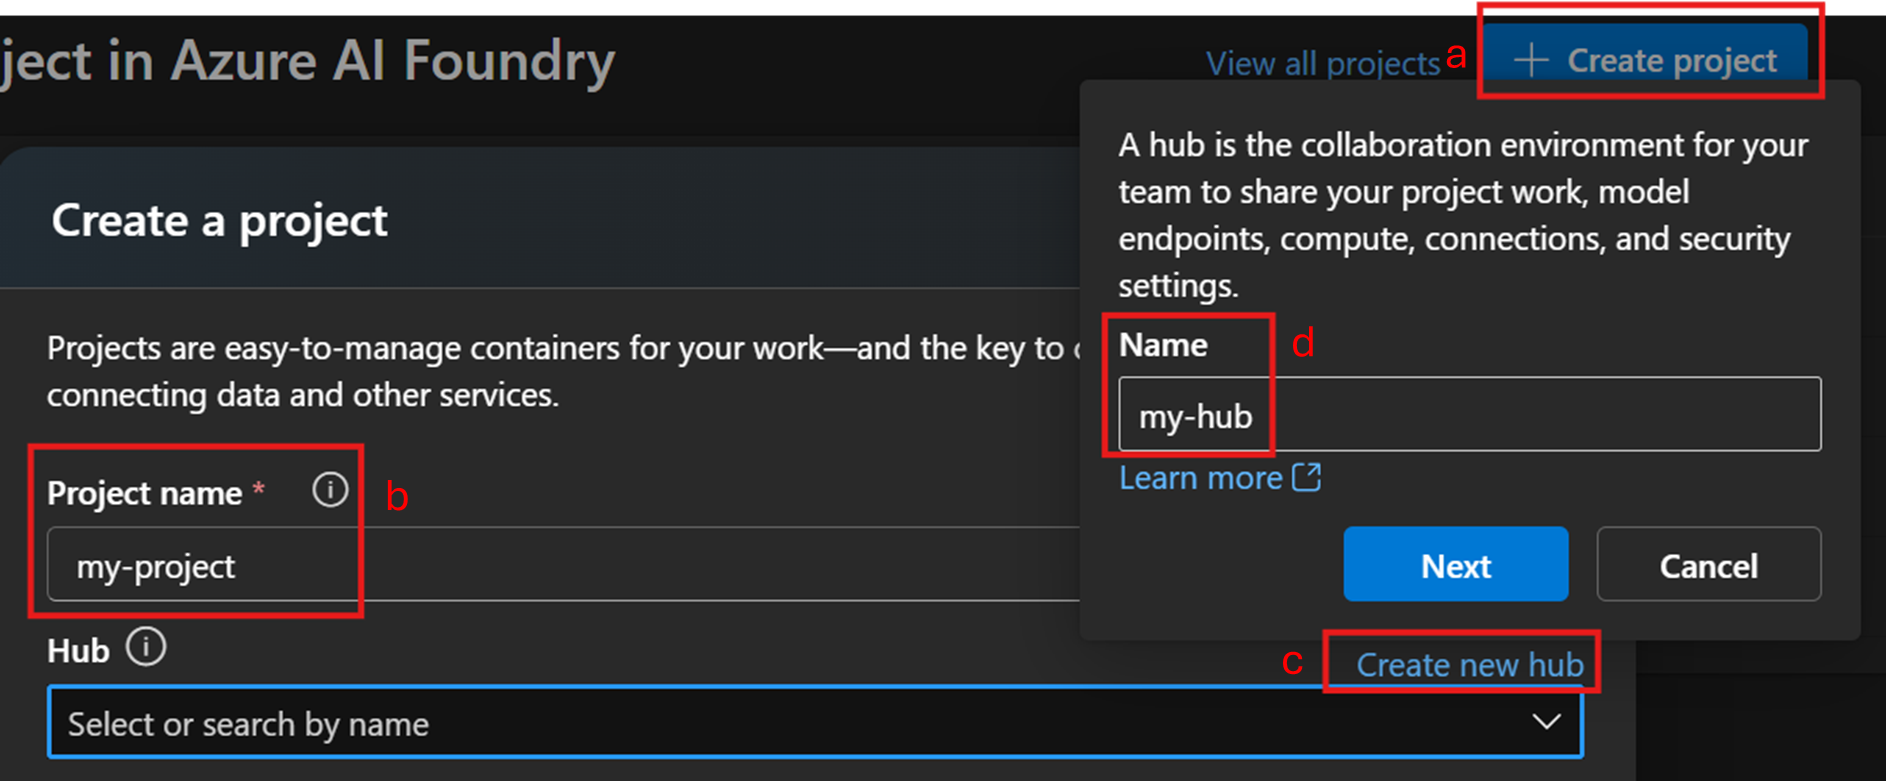

5. Expand the 'Azure resources to be created' section. Notice that a new resource group and some other services are created for you. Select 'Customize'.

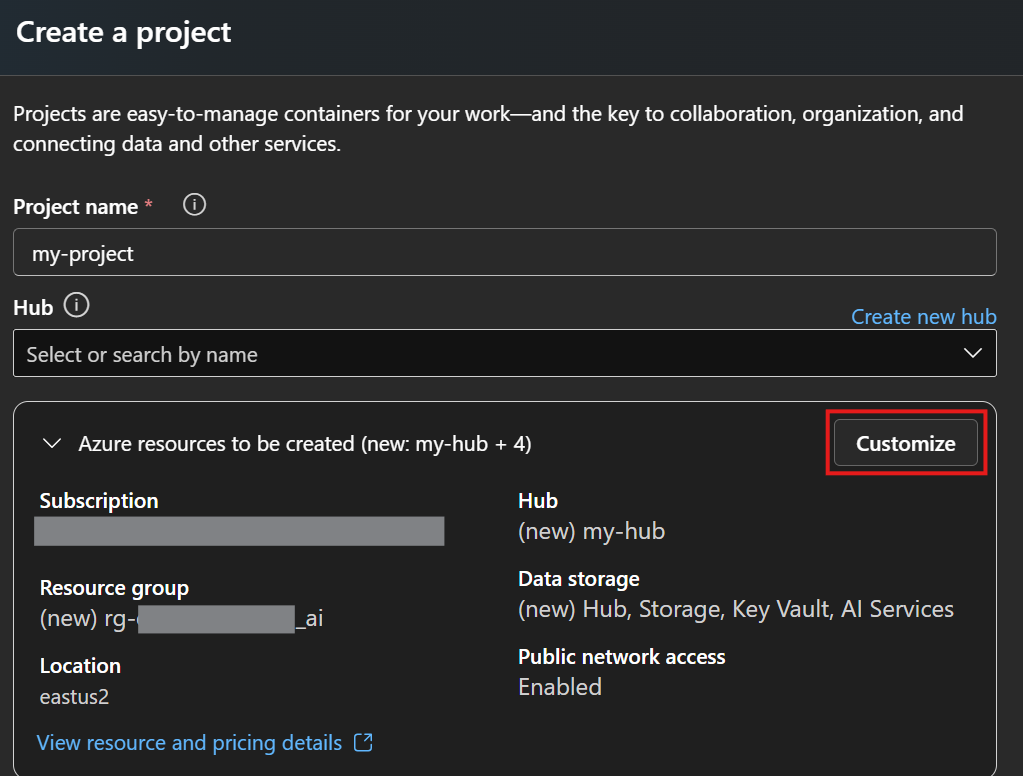

6. We will be using an Azure AI Search service in these labs, so we want to set that up as well. Click 'Create new AI Search' and give it a name. Click 'Next' and proceed to the Review and finish page.

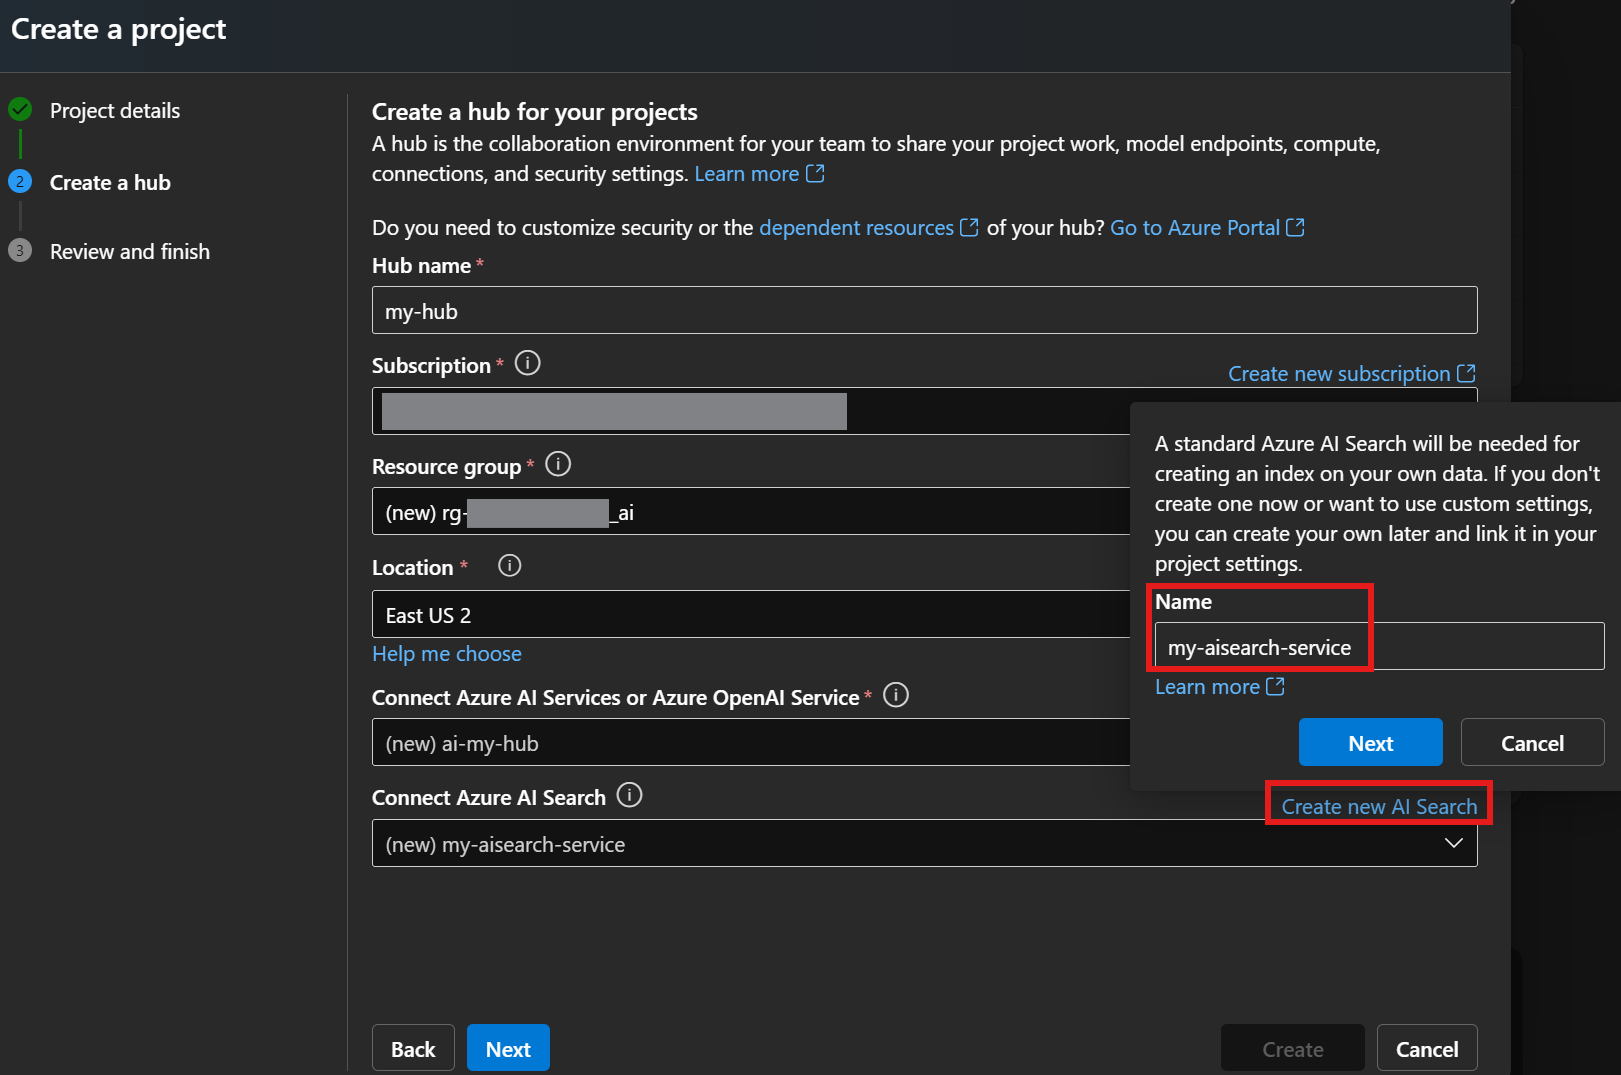

7. Confirm your setup looks something like this and click 'Create':

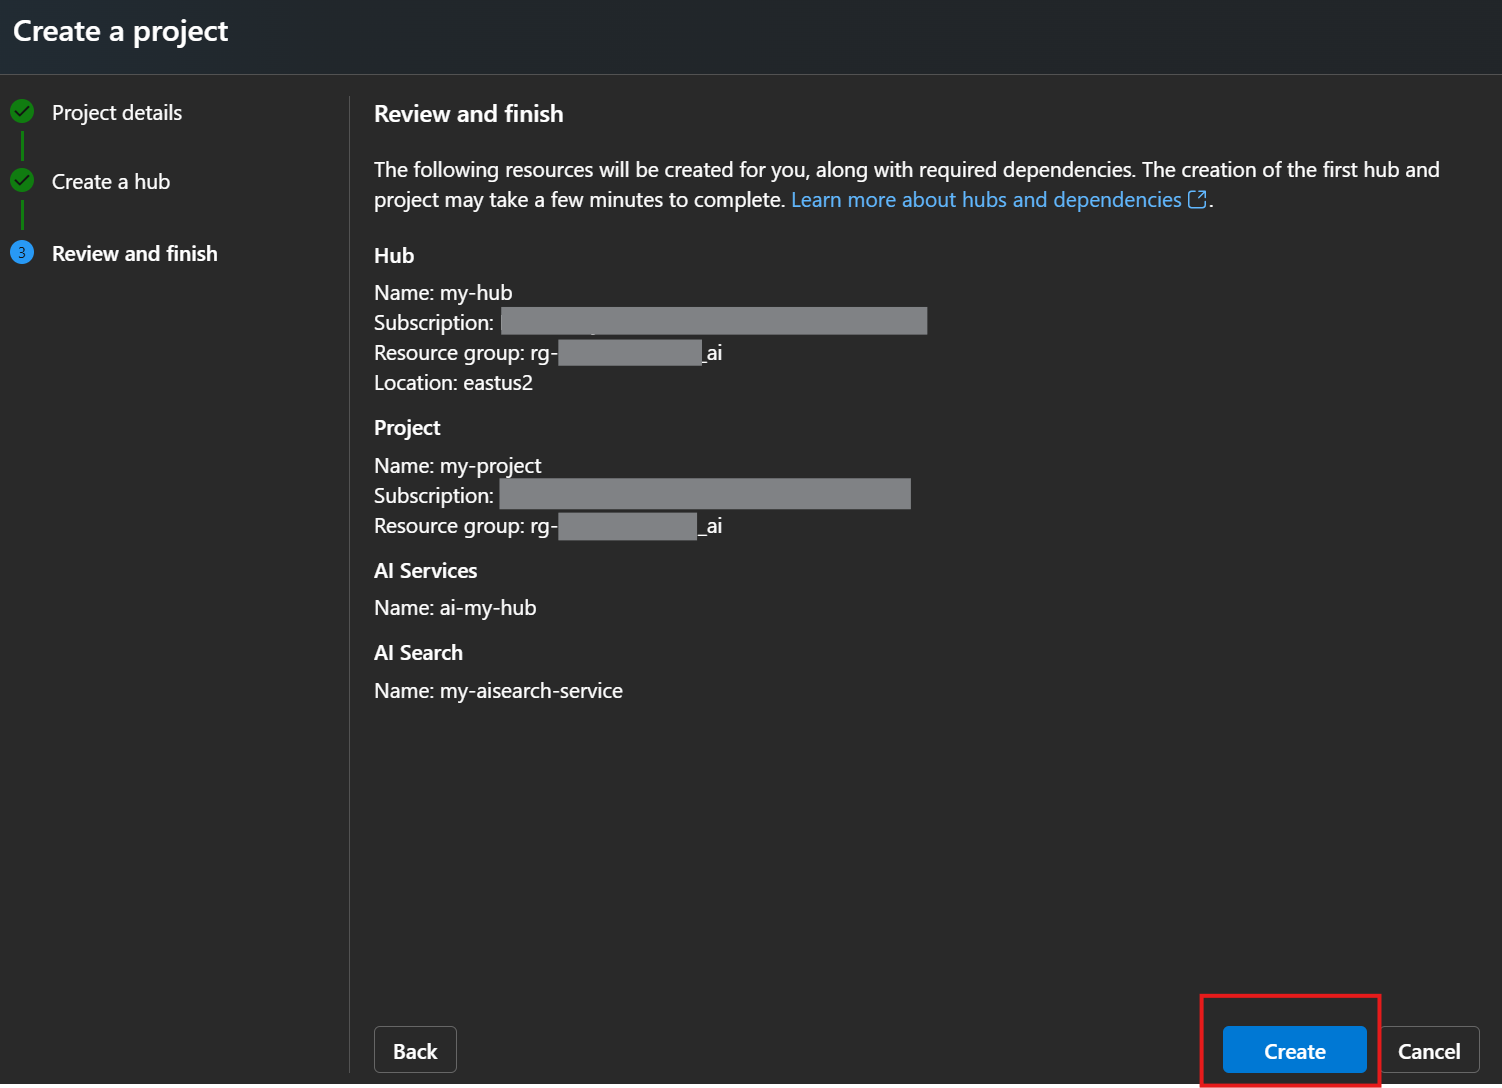

#### Step 2: Deploy gpt-4o model in your AI Foundry project

1. In you AI Foundry project, under My assets section, click on the 'Models + endpoints'.
2. Click on Deploy model and Deploy base model.
3. Select gpt-4o and then press **Confirm**.
4. Select **Customize** and set the **Model version** to 2024-08-06 and the **Tokens per Minute Rate Limit** to 200k.

#### Step 3: Create an Azure OpenAI resource and deploy a text embedding model 

The import and vectorize wizard in Azure AI Search, which will be used in subsequent labs, does not yet support text embedding models within your AI Foundry project. Because of this, we need to create an Azure OpenAI service and deploy a text embedding model there. We will use this text embedding model later to vectorize our health plan documents.

1. Navigate to the resource group that was created upon setting up your AI Foundry Hub and Project.
1. Deploy an Azure OpenAI Service resource in this resource group.
1. In your newly created Azure OpenAI service, click **Go to Azure AI Foundry portal**. Notice that this is outside of your project. 
1. Under the **My assets** section, click on the **Models + endpoints**.
1. Click on **Deploy model** and then **Deploy base model**. 
1. Select `text-embedding-3-large` and deploy it.

#### Step 4: Assign permissions to the Azure AI Search resource

The following steps are needed for the AI search resource to be able to vectorize the health plan documents in Lab 3:
1. Navigate to your Azure AI Search resource and under **Settings** in the left menu, select **Keys**. 
2. Under **API Access control** select **Both**.
3. Nevigate to **Identity** under **Settings**.
    
    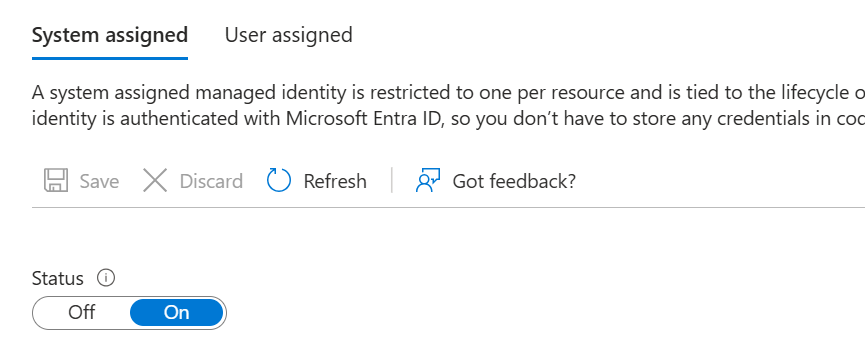
4. Under **System-assigned** set the **Status** to **On** and save.
5. Now navigate to the Storage Account for the project. 
6. Go to the Azure OpenAI resource.
    1. Select **Access control**.

    2. Select **Add**, and then select **Add role assignment**.

    3. Under **Job function roles**, select Cognitive Services OpenAI User, and then select **Next**.

    4. Under **Members**, select Managed identity, and then select Members.

    5. Filter by subscription and resource type (search services), and then select the managed identity of your search service.

    6. Select Review + assign.
7. On the left pane, under **Access control**, assign the Storage Blob Data Reader role to the search service identity. 



#### Step 5: Install dependencies, create a virtual environment, and create an environment variables file

1. Open a new terminal and navigate to the AZURE-AI-AGENTS-LABS project directory, which you cloned from GitHub. Run the below powershell commands to create and activate your virtual environment:
    
    ```powershell
    python -m venv venv
    venv/Scripts/activate
2. Still in the AZURE-AI-AGENTS-LABS project directory, run the below powershell command. This installs all the required packages:
    
    ```powershell
    pip install -r requirements.txt
3. Still in the AZURE-AI-AGENTS-LABS project directory, run the below powershell command. This creates your .env file:
    
    ```powershell
    cp sample.env .env
4. Update your newly created .env file with your environment variables
    1. You'll need your Foundry Project connection string, which you can get from the **Overview** page:
    
    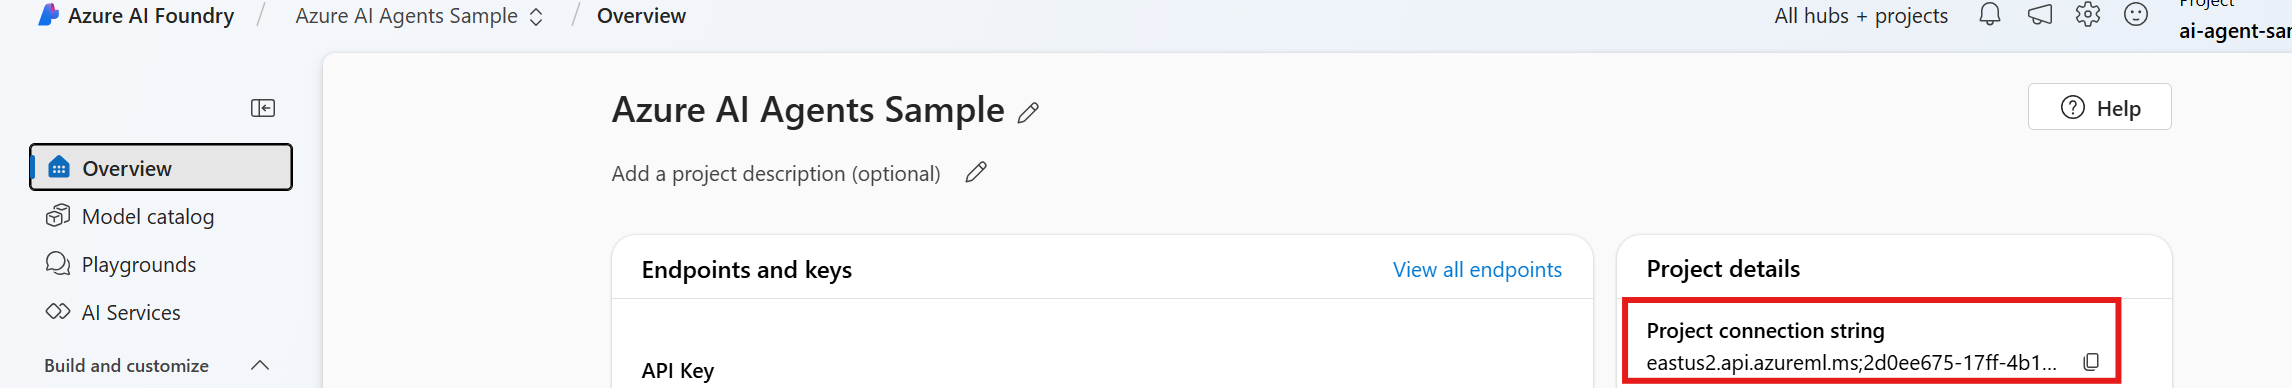

    2. You'll also need your model name, endpoint, and API key. You can get this information by navigating to **Models + endpoints** under **My assets**. Click on the `gpt-4o` model that you deployed and you should see the needed environment variables.

5. Be sure to save your .env file after updating.

#### Step 5: Test your lab environment

To test that your lab was setup successfully, run the below code that sends a message to the deployed model, asking it to tell a joke.

In [1]:
# Import packages
import os
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv

load_dotenv(override=True) # Load environment variables from .env file

True

In [2]:
# Get the project connection string and model from environment variables, which are needed to make a call to the LLM
project_connection_string = os.getenv("AIPROJECT_CONNECTION_STRING")
model = os.getenv("CHAT_MODEL")
api_key = os.getenv("CHAT_MODEL_API_KEY")

# Verify variables
if not project_connection_string or not model:
    raise ValueError("Missing required environment variables. Check AIPROJECT_CONNECTION_STRING and CHAT_MODEL in .env file.")

In [ ]:
# Use the connection string to connect to your Foundry project
try:
    project = AIProjectClient.from_connection_string(
        conn_str=project_connection_string, credential=DefaultAzureCredential()
    )
except Exception as e:
    print(f"Failed to connect to project: {e}")
    raise


In [4]:
## need to login using the command azd auth login
agent = project.agents.create_agent(
        model="gpt-4o",
        name="Agent123",
        instructions="You are helpful AI assistant. Answer the user's questions.",
     
    )
print(f"Created agent, agent ID: {agent.id}")

Created agent, agent ID: asst_lKz9CKOEZIEBm2v2bWOotyyf


In [5]:
    # Create a thread
thread = project.agents.create_thread()
print(f"Created thread, thread ID: {thread.id}")

Created thread, thread ID: thread_VecAiDfqZ6RaVmn6l0R7llTO


In [6]:
    # Get messages from the thread
message = project.agents.create_message(
        thread_id=thread.id,
        role="user",
        content="Hey, can you tell a joke about teddy bear?",
    )
print(f"Created message, ID: {message.id}")


Created message, ID: msg_YVLFDY1ufu2GCFBTEp1vMP5g


In [7]:
run = project.agents.create_and_process_run(thread_id=thread.id, agent_id=agent.id)
    # [END create_and_process_run]
print(f"Run finished with status: {run.status}")

if run.status == "failed":
        print(f"Run failed: {run.last_error}")

Run finished with status: RunStatus.COMPLETED


In [8]:
messages = project.agents.list_messages(thread_id=thread.id)

for msg in messages.data:
    print(f"Message ID: {msg.id}")
    print(f"Role: {msg.role}")
    print("Content:")
    for content in msg.content:
        if content['type'] == 'text':
            print(content['text']['value'])
    print("-" * 50)

# Delete the agent once done
project.agents.delete_agent(agent.id)
("Deleted agent")

Message ID: msg_xnLj6mvbSELrXuCD8t91Oxl9
Role: MessageRole.AGENT
Content:
Sure! Why did the teddy bear say no to dessert?  

Because it was already stuffed!
--------------------------------------------------
Message ID: msg_YVLFDY1ufu2GCFBTEp1vMP5g
Role: MessageRole.USER
Content:
Hey, can you tell a joke about teddy bear?
--------------------------------------------------


'Deleted agent'

### Confirm project connectivity to Azure OpenAI model

In [11]:
aoai_client = project.inference.get_azure_openai_client(api_version="2024-06-01")

response = aoai_client.chat.completions.create(
    model="gpt-4o", # Model deployment name
    messages=[
        {
            "role": "user",
            "content": "How many feet are in a mile?",
        },
    ],
)

print(response.choices[0].message.content)

There are 5,280 feet in a mile.
